In [1]:
import pandas as pd
import numpy as np
import time
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

Pour analyser la pertinence du modèle que nous sélectionnerons, nous devons créer une fonction qui pénalise les mauvaises prédiction et plus particulièrement les False Negative. Ce sont des prédictions du modèle qui prédise un 0 alors que nous attendons un 1. Cette prédiction est plus dangereuse pour la pertinence du modèle car si nous prédisons un remboursement probable d'un crédit et que cela n'est pas le cas, cela impacte directement la rentabilité de la banque, ce qui n'est pas souhaitable.

In [2]:
def custom_penalty(y_test, y_pred):
    y_test = y_test.to_numpy().flatten()
    penalty = 0.0
    sum_penalty = 0
    
    for yt, yp in zip(y_test, y_pred):
        if yt == 1 and yp == 0:
            penalty = penalty + 10
            sum_penalty = sum_penalty +1
        elif yt == 0 and yp == 1:
            penalty = penalty + 1
            sum_penalty = sum_penalty +1
            
    score = (penalty/len(y_test))*0.1#/ (sum_penalty + 1e-7) # Prevents zero division
    return 1 - score

## SVM

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  # pour la classification, ou SVR pour la régression
from sklearn.metrics import accuracy_score, classification_report

In [4]:
X_train_hybrid = pd.read_csv('X_train_CSV_hybrid.csv')
X_test_hybrid = pd.read_csv('X_test_CSV_hybrid.csv')
y_train_hybrid = pd.read_csv('y_train_CSV_hybrid.csv')
y_test_hybrid = pd.read_csv('y_test_CSV_hybrid.csv')

In [5]:
selected_columns = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'NAME_FAMILY_STATUS_Married',\
                    'FLAG_OWN_CAR', 'DAYS_BIRTH', 'CODE_GENDER', 'FLAG_DOCUMENT_3',\
                    'DAYS_ID_PUBLISH', 'NAME_CONTRACT_TYPE',\
                    'WALLSMATERIAL_MODE_Panel', \
                    'FLAG_DOCUMENT_6',\
                    'FLAG_PHONE', 'FLAG_DOCUMENT_8',\
                    'WEEKDAY_APPR_PROCESS_START_MONDAY',\
                    'DAYS_EMPLOYED']
X_train_hybrid = X_train_hybrid[selected_columns].copy()
X_test_hybrid = X_test_hybrid[selected_columns].copy()

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hybrid)
X_test_scaled = scaler.transform(X_test_hybrid)

In [9]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}
svm = SVC(kernel='linear', cache_size=1000)

grid_search = GridSearchCV(svm, param_grid, scoring=custom_penalty, cv=5)
grid_search.fit(X_train_scaled, y_train_hybrid.values.ravel())
grid_search

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: custom_penalty() takes 2 positional arguments but 3 were given

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: custom_penalty() takes 2 positional arguments but 3 were given

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: custom_penalty() takes 2 positional arguments but 3 were given

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: custom_penalty() takes 2 positional arguments but 3 were given

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model

GridSearchCV(cv=5, estimator=SVC(cache_size=1000, kernel='linear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring=<function custom_penalty at 0x7fcbdafe8160>)

In [10]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test_scaled, y_test_hybrid)
print(best_params)
print(best_score)
print(best_model)
print(best_model_score)

{'C': 0.01}
nan
SVC(C=0.01, cache_size=1000, kernel='linear')
0.7005


In [11]:
svm_model = SVC(C=0.01, kernel='linear', cache_size=1000)

In [12]:
scores = cross_val_score(svm_model, X_train_scaled, y_train_hybrid, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Scores de validation croisée: [-0.301875 -0.323125 -0.31625  -0.3025   -0.313125]


In [13]:
start_time = time.time()
svm_model.fit(X_train_scaled, y_train_hybrid)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Le temps de traitement est de : 1.8123929500579834 secondes


In [14]:
y_pred_hybrid = svm_model.predict(X_test_scaled)

In [15]:
custom_penalty(y_test_hybrid, y_pred_hybrid)

0.7851

In [16]:
f1 = f1_score(y_test_hybrid, y_pred_hybrid)
print(f"F1-score : {f1}")

F1-score : 0.5888812628689086


In [17]:
fpr, tpr, thresholds = roc_curve(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid = roc_auc_score(y_test_hybrid, y_pred_hybrid)
auc_score_hybrid

0.6743226600985222

In [18]:
explainer = shap.Explainer(svm_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


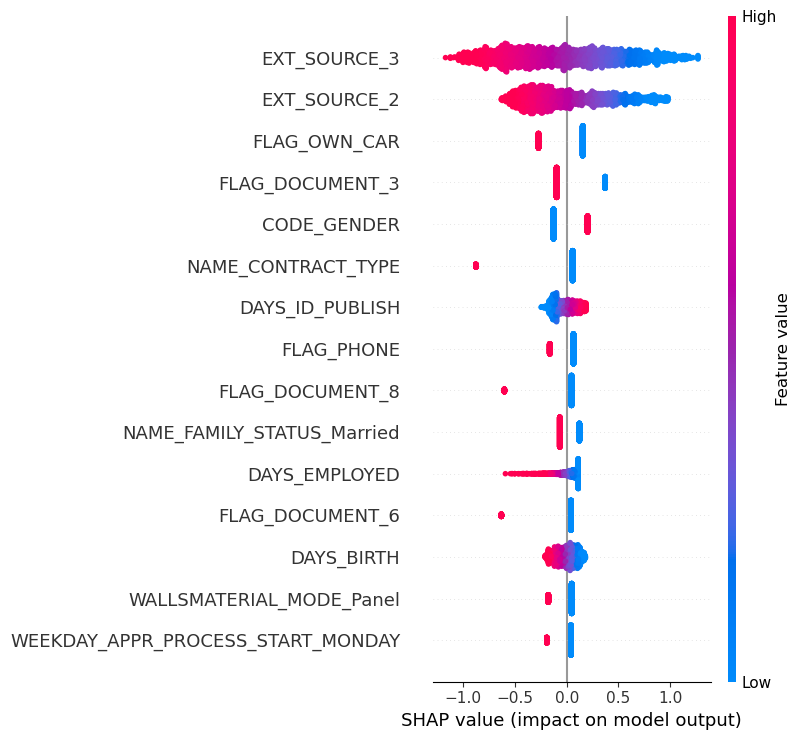

In [19]:
feature_names = X_test_hybrid.columns.tolist()
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show = False)

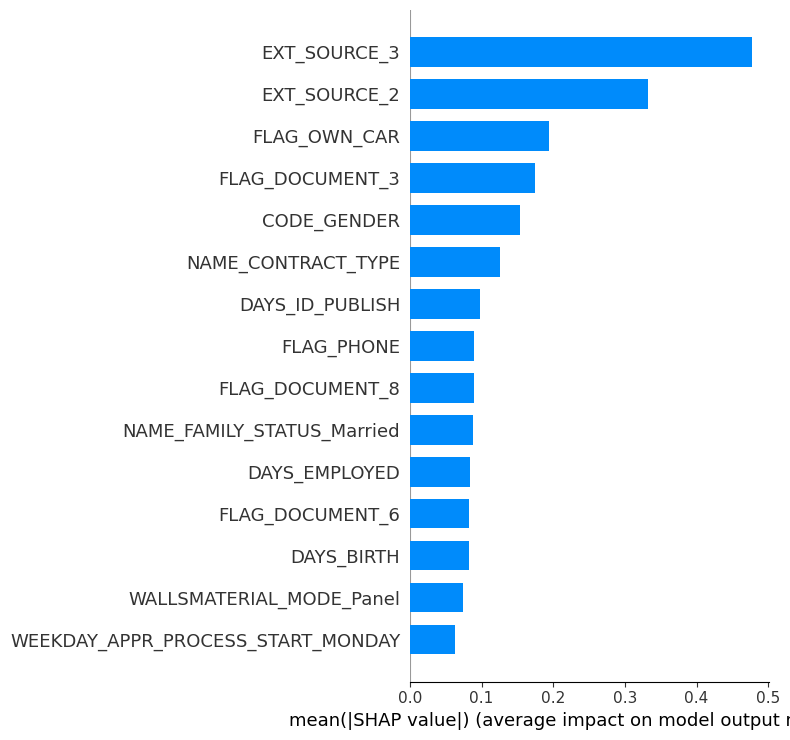

In [20]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=feature_names)

In [21]:
X_train_under = pd.read_csv('X_train_CSV_under.csv')
X_test_under = pd.read_csv('X_test_CSV_under.csv')
y_train_under = pd.read_csv('y_train_CSV_under.csv')
y_test_under = pd.read_csv('y_test_CSV_under.csv')

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_under)
X_test_scaled = scaler.transform(X_test_under)

In [23]:
svm_model = SVC(C=0.01, kernel='linear', cache_size=1000)

In [24]:
scores = cross_val_score(svm_model, X_train_scaled, y_train_hybrid, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Scores de validation croisée: [-0.4175   -0.418125 -0.41375  -0.41375  -0.418125]


In [25]:
start_time = time.time()
svm_model.fit(X_train_scaled, y_train_under)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Le temps de traitement est de : 4.856673002243042 secondes


In [26]:
y_pred_under = svm_model.predict(X_test_scaled)

In [27]:
custom_penalty(y_test_under, y_pred_under)

0.8248

In [28]:
f1 = f1_score(y_test_under, y_pred_under)
print(f"F1-score : {f1}")

F1-score : 0.6725297465080187


In [29]:
fpr, tpr, thresholds = roc_curve(y_test_under, y_pred_under)
auc_score_under = roc_auc_score(y_test_under, y_pred_under)
auc_score_under

0.6831179763752967